# Seaborn Cheat Sheet & Pandas Data Manipulation

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt

In [2]:
#Read file into dataframe
dep_energy_report = pd.read_csv('MER_T07_01.csv')
dep_energy_report.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,ELEGPUS,194913,291.1,1,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours
1,ELEGPUS,195013,329.141,1,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours
2,ELEGPUS,195113,370.673,1,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours
3,ELEGPUS,195213,399.224,1,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours
4,ELEGPUS,195313,442.665,1,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours


In [3]:
dep_energy_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSN           7172 non-null   object
 1   YYYYMM        7172 non-null   int64 
 2   Value         7172 non-null   object
 3   Column_Order  7172 non-null   int64 
 4   Description   7172 non-null   object
 5   Unit          7172 non-null   object
dtypes: int64(2), object(4)
memory usage: 336.3+ KB


## Transform Date

In [4]:
str_series = dep_energy_report['YYYYMM'].to_string().split("\n")

year = []
month = []

for x in str_series:
    temp = x[-6:]
    year.append(int(temp[:4]))
    month.append(int(temp[-2:]))

In [5]:
dep_energy_report['Year'] = year
dep_energy_report['Month'] = month
dep_energy_report.drop(columns = ['YYYYMM'], inplace = True)

In [6]:
dep_energy_report = dep_energy_report[dep_energy_report['Value'] != "Not Available"]
dep_energy_report['Value'] = dep_energy_report['Value'].astype(float)

In [7]:
dep_energy_report['Value'].describe()

count    6708.000000
mean      198.916884
std       542.177741
min        -3.489000
25%         2.540000
50%        13.478500
75%       244.819250
max      4178.277000
Name: Value, dtype: float64

In [8]:
dep_ann = dep_energy_report[dep_energy_report['Month'] == 13]
dep_month = dep_energy_report[dep_energy_report['Month'] != 13]

In [9]:
#Make new df for annual analysis
dep_new = dep_ann[['Year','Month']]
#join all desired columns by selecting msn title & 'VALUE'
for des in list(dep_ann['Description'].unique()):
    dep_new = dep_new.join(dep_ann[dep_ann['Description'] == des]['Value'])
    dep_new.rename(columns = {"Value":des}, inplace=True)
#Set Index to Year (Annual analysis)
dep_new.set_index(dep_ann['Year'],drop = True ,inplace = True)
#Drop year and month columns
dep_new.drop(columns = ['Year','Month'], inplace = True)
dep_new = dep_new.groupby(level=0).sum()
dep_new

,"Electricity Net Generation, Electric Power Sector","Electricity Net Generation, Commercial Sector","Electricity Net Generation, Industrial Sector","Electricity Net Generation, Total",Electricity Imports,Electricity Exports,Electricity Net Imports,Transmission and Distribution Losses and Unaccounted for,"Electricity Retail Sales, Total",Electricity Direct Use,"Electricity End Use, Total"
Year,,,,,,,,,,,
1949,291.100,0.000,5.025,296.124,1.764,0.175,1.588,43.201,254.511,0.000,254.511
1950,329.141,0.000,4.946,334.088,1.933,0.147,1.786,44.430,291.443,0.000,291.443
1951,370.673,0.000,4.626,375.298,2.387,0.200,2.187,47.201,330.285,0.000,330.285
1952,399.224,0.000,4.606,403.829,2.506,0.237,2.269,49.934,356.164,0.000,356.164
1953,442.665,0.000,4.384,447.049,2.437,0.429,2.008,52.840,396.217,0.000,396.217
...,...,...,...,...,...,...,...,...,...,...,...
2016,3918.078,12.706,145.890,4076.675,72.716,6.214,66.502,240.871,3762.462,139.844,3902.306
2017,3877.453,13.060,143.758,4034.271,65.685,9.371,56.314,226.114,3723.356,141.114,3864.470
2018,4018.167,13.312,146.798,4178.277,58.261,13.804,44.456,219.434,3859.185,144.114,4003.299


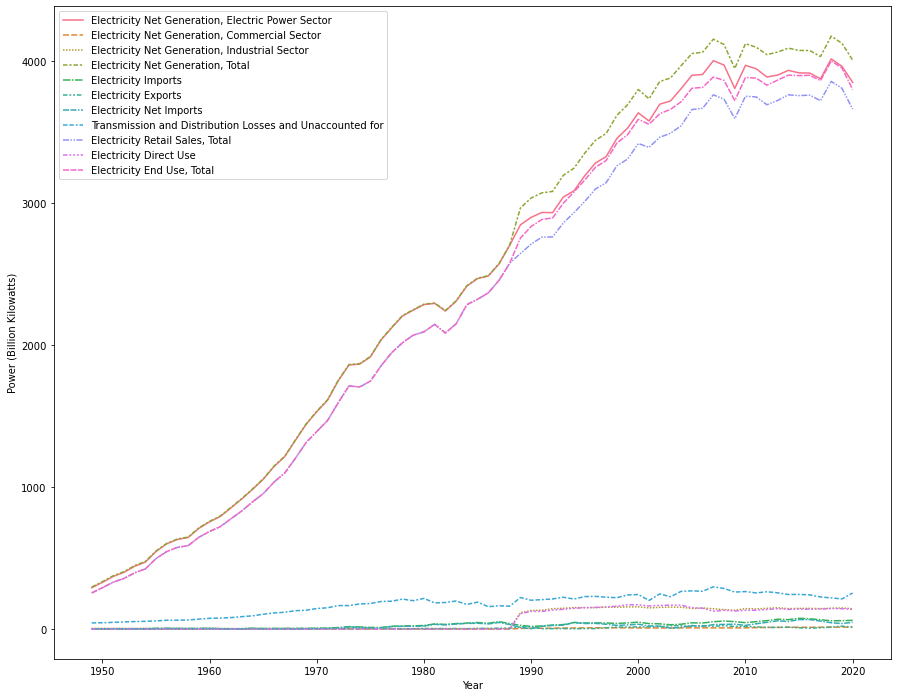

In [10]:
#Plot all data
plt.figure(figsize = (15,12))
plt.xlabel('Year')
plt.ylabel('Power (Billion Kilowatts)')
sns.lineplot(data = dep_new)
plt.show()

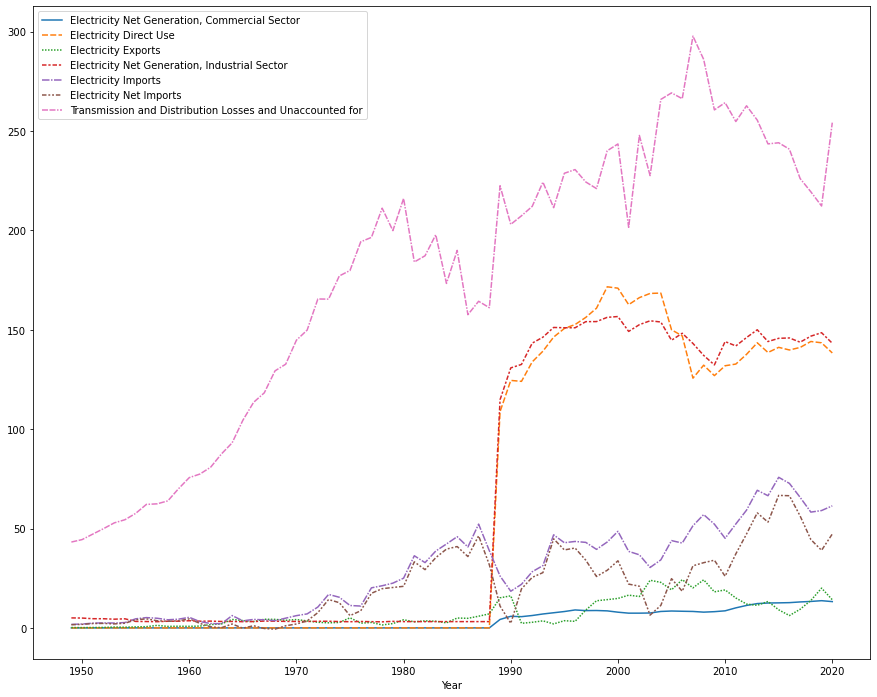

In [11]:
#Plot all relevant
plt.figure(figsize = (15,12))
sns.lineplot(data = dep_new[['Electricity Net Generation, Commercial Sector', 
                             'Electricity Direct Use','Electricity Exports',
                            'Electricity Net Generation, Industrial Sector',
                            'Electricity Imports',
                            'Electricity Net Imports',
                            'Transmission and Distribution Losses and Unaccounted for']])
plt.show()

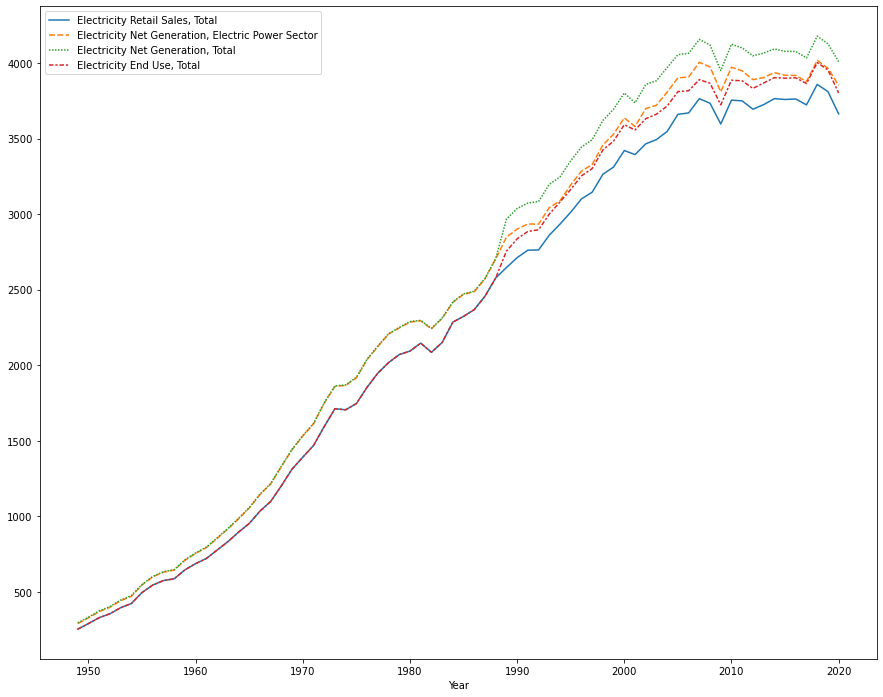

In [12]:
#Plot all relevant
plt.figure(figsize = (15,12))
sns.lineplot(data = dep_new[['Electricity Retail Sales, Total','Electricity Net Generation, Electric Power Sector', 
                             'Electricity Net Generation, Total','Electricity End Use, Total']])
plt.show()

In [13]:
dep_ann.groupby(['MSN','Description', 'Unit']).size().reset_index().rename(columns={0:'count'})

,MSN,Description,Unit,count
0,ELC5PUS,"Electricity Net Generation, Commercial Sector",Billion Kilowatthours,32
1,ELDUPUS,Electricity Direct Use,Billion Kilowatthours,32
2,ELEGPUS,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours,72
3,ELETPUS,"Electricity Net Generation, Total",Billion Kilowatthours,72
4,ELEXPUS,Electricity Exports,Billion Kilowatthours,72
5,ELI5PUS,"Electricity Net Generation, Industrial Sector",Billion Kilowatthours,72
6,ELIMPUS,Electricity Imports,Billion Kilowatthours,72
7,ELNIPUS,Electricity Net Imports,Billion Kilowatthours,72
8,ELTCPUS,"Electricity End Use, Total",Billion Kilowatthours,72
9,ELUNPUS,Transmission and Distribution Losses and Unacc...,Billion Kilowatthours,72


In [14]:
dep_new['Loss Percentage'] = dep_new['Transmission and Distribution Losses and Unaccounted for']/dep_new['Electricity Net Generation, Total']

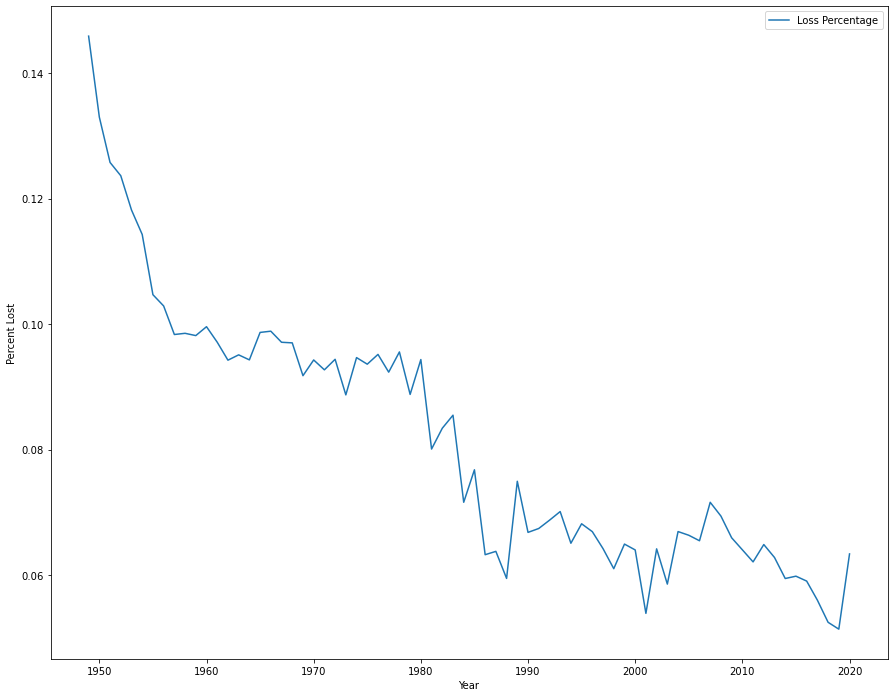

In [15]:
#Plot all relevant
plt.figure(figsize = (15,12))
sns.lineplot(data = dep_new[['Loss Percentage']])
plt.ylabel('Percent Lost')
plt.show()

## Monthly

In [16]:
year_str = list(dep_month['Year'].astype('str'))
month_str = list(dep_month['Month'].astype('str'))
dates = []

for i in range(len(year_str)):
    if int(month_str[i]) < 10:
        dates.append('0'+month_str[i]+'.01.'+year_str[i])
    else:
        dates.append(month_str[i]+'.01.'+year_str[i])

In [17]:
dep_month['dates'] = pd.to_datetime(dates)
dep_month

,MSN,Value,Column_Order,Description,Unit,Year,Month,dates
24,ELEGPUS,159.913,1,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours,1973,1,1973-01-01
25,ELEGPUS,143.257,1,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours,1973,2,1973-02-01
26,ELEGPUS,147.847,1,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours,1973,3,1973-03-01
27,ELEGPUS,139.292,1,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours,1973,4,1973-04-01
28,ELEGPUS,147.088,1,"Electricity Net Generation, Electric Power Sector",Billion Kilowatthours,1973,5,1973-05-01
...,...,...,...,...,...,...,...,...
7166,ELTCPUS,323.130,11,"Electricity End Use, Total",Billion Kilowatthours,2020,12,2020-12-01
7168,ELTCPUS,333.354,11,"Electricity End Use, Total",Billion Kilowatthours,2021,1,2021-01-01
7169,ELTCPUS,308.878,11,"Electricity End Use, Total",Billion Kilowatthours,2021,2,2021-02-01
7170,ELTCPUS,304.303,11,"Electricity End Use, Total",Billion Kilowatthours,2021,3,2021-03-01


In [18]:
dep2 = dep_month[['dates','Month','Year','Unit','MSN']]

for des in list(dep_month['Description'].unique()):
    dep2 = dep2.join(dep_month[dep_month['Description'] == des]['Value'])
    dep2.rename(columns = {"Value":des}, inplace=True)

dep2.set_index(dep_month['dates'],inplace = True)
dep2.drop(columns = ['dates','Year','Month'], inplace = True)
dep2 = dep2.groupby(level=0).sum()

dep2

,"Electricity Net Generation, Electric Power Sector","Electricity Net Generation, Commercial Sector","Electricity Net Generation, Industrial Sector","Electricity Net Generation, Total",Electricity Imports,Electricity Exports,Electricity Net Imports,Transmission and Distribution Losses and Unaccounted for,"Electricity Retail Sales, Total",Electricity Direct Use,"Electricity End Use, Total"
dates,,,,,,,,,,,
1973-01-01,159.913,0.000,0.305,160.218,1.431,0.218,1.213,16.925,144.505,0.000,144.505
1973-02-01,143.257,0.000,0.282,143.539,1.292,0.197,1.095,5.088,139.546,0.000,139.546
1973-03-01,147.847,0.000,0.312,148.158,1.431,0.218,1.213,12.269,137.102,0.000,137.102
1973-04-01,139.292,0.000,0.298,139.589,1.385,0.211,1.174,9.397,131.366,0.000,131.366
1973-05-01,147.088,0.000,0.307,147.395,1.431,0.218,1.213,17.247,131.361,0.000,131.361
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,331.059,1.105,12.806,344.970,5.129,0.807,4.322,26.163,310.828,12.302,323.130
2021-01-01,337.092,1.121,12.602,350.815,5.086,0.941,4.145,21.607,321.219,12.135,333.354
2021-02-01,315.905,1.013,10.101,327.019,4.024,1.097,2.927,21.067,299.051,9.828,308.878


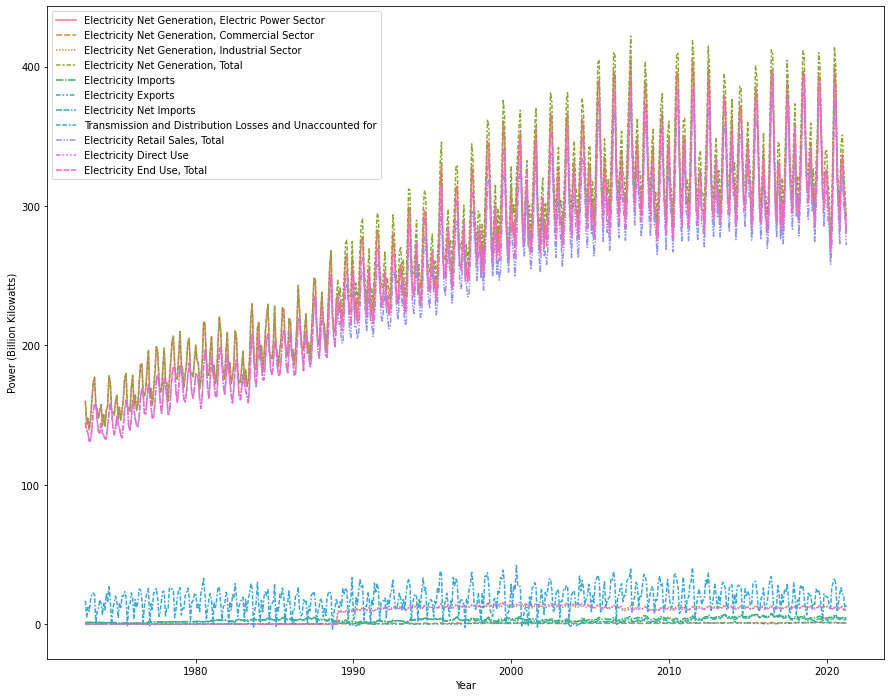

In [30]:
#Plot all data
plt.figure(figsize = (15,12))
plt.xlabel('Year')
plt.ylabel('Power (Billion Kilowatts)')
sns.lineplot(data = dep2)
plt.show()

In [32]:
dep_new.to_csv('Electrical Power Generation Annual 1949 - 2020.csv')
dep2.to_csv('Electrical Power Generation Monthly 1973 - 04.2021.csv')

# Forecasting Monthly Energy Production (Electricity Net Generation Total)
## Possible Explanatory Features:
- Temperature (Monthly Range, Monthly Max, Monthly Min, Monthly Average)
- Precipitation (Inches)
- Cost (Dollars/Killowatt Hour)

In [38]:
def get_mape(actual, predicted):
    return np.round(np.mean(np.abs((actual-predicted) / actual))*100,2)

## Triple Exponential Smoothing

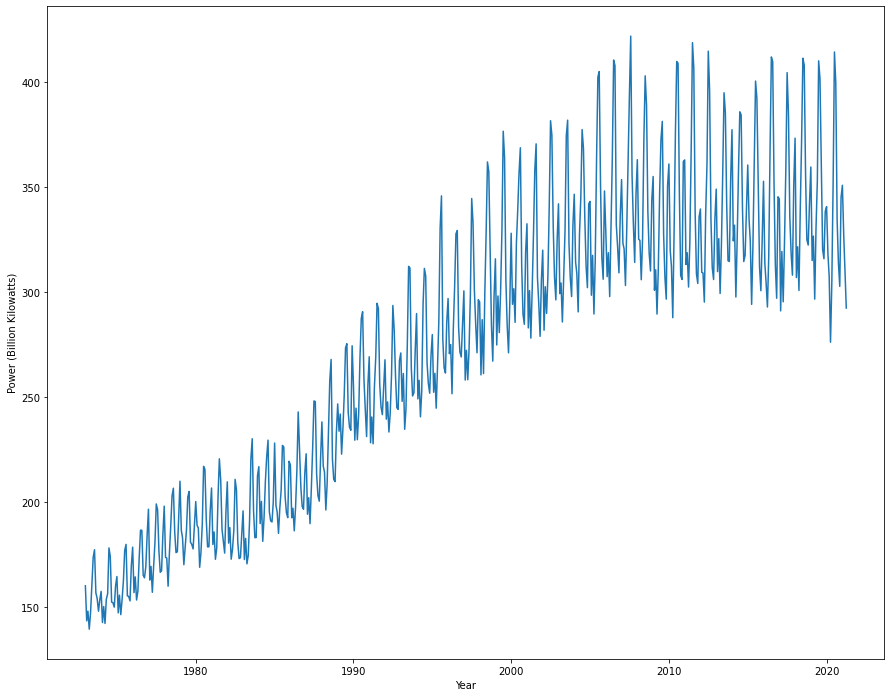

In [33]:
#Plot all data
plt.figure(figsize = (15,12))
plt.xlabel('Year')
plt.ylabel('Power (Billion Kilowatts)')
sns.lineplot(data = dep2['Electricity Net Generation, Total'])
plt.show()

In [111]:
fit3 = ExponentialSmoothing(np.asarray(dep2['Electricity Net Generation, Total'][:567].values),seasonal_periods=12,trend='add', seasonal='add',).fit()
fit3.summary()

Dep. Variable:,endog,No. Observations:,567
Model:,ExponentialSmoothing,SSE,38063.550
Optimized:,True,AIC,2417.172
Trend:,Additive,BIC,2486.618
Seasonal:,Additive,AICC,2418.420
Seasonal Periods:,12,Date:,"Tue, 10 Aug 2021"
Box-Cox:,False,Time:,12:16:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3096663,alpha,True
smoothing_trend,1.3561e-08,beta,True


RMS: 10.714798097216118
MAPE: 2.76


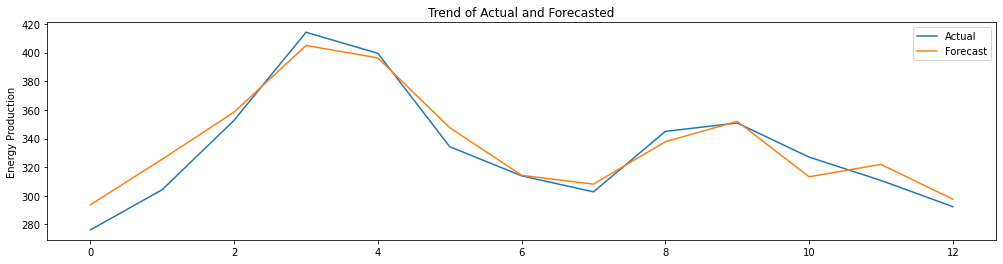

In [118]:
train_data = dep2['Electricity Net Generation, Total'][:567]
test_data = dep2['Electricity Net Generation, Total'][567:]
y_hat_avg = test_data.copy()
y_hat_avg['Triple_Smoothed_Forecast'] = fit3.forecast(len(test_data))
rms = math.sqrt(mean_squared_error(test_data, y_hat_avg.Triple_Smoothed_Forecast))
print("RMS: " + str(rms))
print("MAPE: " + str(get_mape(test_data,y_hat_avg.Triple_Smoothed_Forecast)))

plt.figure(figsize=(17,4))
plt.ylabel('Energy Production')
plt.title('Trend of Actual and Forecasted')
plt.plot([x for x in range(len(test_data))],test_data,y_hat_avg['Triple_Smoothed_Forecast'])
plt.legend(['Actual','Forecast'])
plt.show()